In [5]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import randint

Finding best hyperparameters using RandomizedSearchCV for Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters for RF: {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 121}
Training the best Random Forest model on full dataset...

Random Forest Model Evaluation:
Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1-score: 100.00%
Training Time: 0.3069 seconds
Prediction Time: 0.0331 seconds


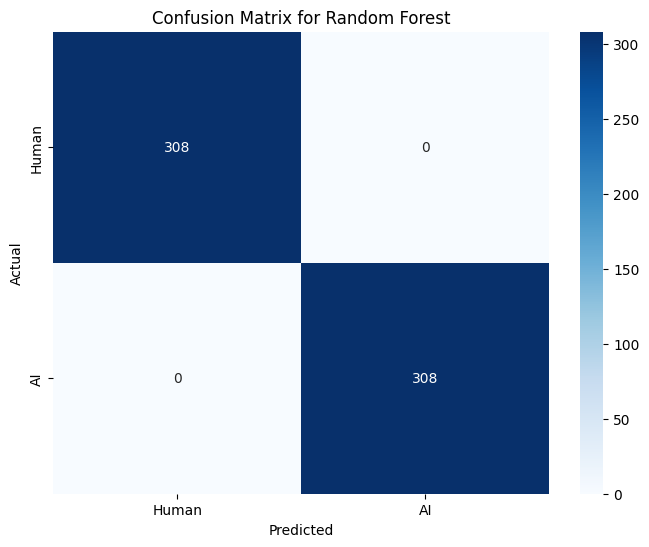

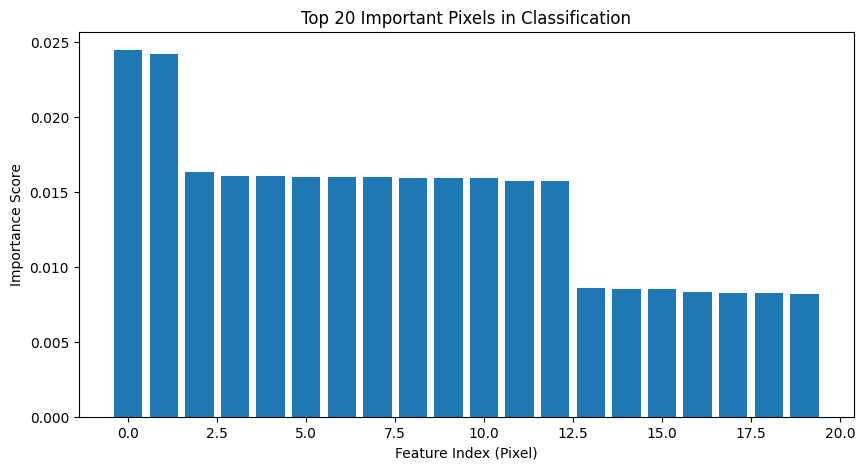

In [8]:
# Random Forest

# Load the preprocessed dataset
file_path = r"C:\Users\Carine\Desktop\data\human_vs_ai_dataset.npz"
data = np.load(file_path)

# Extract training & validation data
X_train, y_train = data["X_train"], data["y_train"]
X_val, y_val = data["X_val"], data["y_val"]

# Flatten images for Random Forest (convert from 128x128 to 1D)
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

# Define hyperparameter grid for RandomizedSearchCV
param_dist_rf = {
    'n_estimators': randint(50, 200),  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Allow deep trees
    'min_samples_split': [2, 5, 10],  # Control overfitting
    'min_samples_leaf': [1, 2, 4],  # Prevent small leaf nodes
    'max_features': ['sqrt', 'log2', None],  # Limit number of features per split
    'bootstrap': [True, False]  # Use bootstrap sampling
}

# Take a subset for initial testing due to computational constraints
n_samples = min(5000, X_train.shape[0])  # Adjust based on available data size
X_train_small, y_train_small = X_train[:n_samples], y_train[:n_samples]

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Use RandomizedSearchCV for hyperparameter tuning
print("Finding best hyperparameters using RandomizedSearchCV for Random Forest...")
random_search_rf = RandomizedSearchCV(
    rf, param_dist_rf, n_iter=20, cv=3, n_jobs=-1, verbose=1, random_state=42
)

# Start hyperparameter tuning
start_time = time.time()
random_search_rf.fit(X_train_small, y_train_small)
grid_search_time_rf = time.time() - start_time

# Best hyperparameters
best_params_rf = random_search_rf.best_params_
print(f"Best Parameters for RF: {best_params_rf}")

# Train the best Random Forest model on the full dataset
best_rf = RandomForestClassifier(
    **best_params_rf, random_state=42, n_jobs=-1
)

print("Training the best Random Forest model on full dataset...")
start_time = time.time()
best_rf.fit(X_train, y_train)
training_time_rf = time.time() - start_time

# Start time for prediction
start_time = time.time()
y_pred_rf = best_rf.predict(X_val)
prediction_time_rf = time.time() - start_time

# Evaluate the model
accuracy_rf = accuracy_score(y_val, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_val, y_pred_rf)
classification_rep_rf = classification_report(y_val, y_pred_rf, output_dict=True)

# Extract precision, recall, and F1-score (weighted average)
precision_rf = classification_rep_rf["weighted avg"]["precision"]
recall_rf = classification_rep_rf["weighted avg"]["recall"]
f1_rf = classification_rep_rf["weighted avg"]["f1-score"]

# Print evaluation metrics
print("\nRandom Forest Model Evaluation:")
print(f"Accuracy: {accuracy_rf * 100:.2f}%")
print(f"Precision: {precision_rf * 100:.2f}%")
print(f"Recall: {recall_rf * 100:.2f}%")
print(f"F1-score: {f1_rf * 100:.2f}%")
print(f"Training Time: {training_time_rf:.4f} seconds")
print(f"Prediction Time: {prediction_time_rf:.4f} seconds")

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest")
plt.show()

# Feature Importance Analysis
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top 20 most important features (pixels)
plt.figure(figsize=(10, 5))
plt.title("Top 20 Important Pixels in Classification")
plt.bar(range(20), importances[indices[:20]], align="center")
plt.xlabel("Feature Index (Pixel)")
plt.ylabel("Importance Score")
plt.show()

In [9]:
from scipy.ndimage import gaussian_filter
from sklearn.svm import SVC

# Add slight noise to images
X_train_noisy = np.array([gaussian_filter(img, sigma=0.5) for img in X_train])
X_val_noisy = np.array([gaussian_filter(img, sigma=0.5) for img in X_val])

# Train SVM on noisy data
svm_model = SVC(kernel="linear", C=1)
svm_model.fit(X_train_noisy, y_train)
svm_acc_noisy = svm_model.score(X_val_noisy, y_val)

print(f"SVM Accuracy after adding noise: {svm_acc_noisy * 100:.2f}%")


SVM Accuracy after adding noise: 99.19%
